In [2]:
!pip install tqdm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 60 kB 2.5 MB/s eta 0:00:011


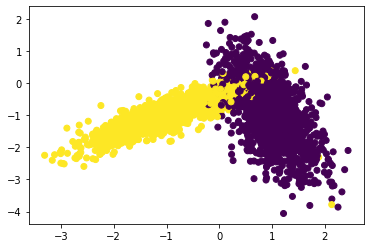

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

## Generating 10 number numbers

In [4]:
def generate_10_random_numbers(a):
  if a[0] < a[1]:
    r = np.random.uniform(a[0],a[1],10)
    r = list(r.astype(int))
    r.sort()
    if len(r) == len(set(r)):
      return r
    else:
      r = generate_10_random_numbers(a)
      return r
  else:
    print('Error: param_range: its a tuple like (a,b) a < b ')
    return 0

## divide numbers ranging from  0 to len(X_train) into 3 folds

In [5]:
def divide_training_dataset_to_k_folds(x_train,y_train,folds):
    temp = len(x_train)/folds
    x_train = x_train.tolist()
    y_train = y_train.tolist()
    group = []
    label = []
    end = 0.0
    while end < len(x_train):
      group.append(x_train[int(end):int(end + temp)])
      label.append(y_train[int(end):int(end + temp)])
      end += temp
    return group,label

## defining RandomSearch Function

In [6]:
from sklearn.metrics import accuracy_score
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):

    #Generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    
    params = generate_10_random_numbers(param_range)
    if params == 0:
      exit()
  
  
    # divide numbers ranging from  0 to len(X_train) into groups= folds
   
    temp = len(x_train)/folds
    temp = int(temp) 
    groups,labels = divide_training_dataset_to_k_folds(x_train,y_train,folds)
    
    train_scores = []
    test_scores  = []    
    for k in tqdm(params):
      for i in range(folds):
        trainscores_folds = []
        testscores_folds  = []
        X_train = [groups[iter] for iter in range(folds) if iter != i]
        X_train = [j for sublist in X_train for j in sublist]
        Y_train = [labels[iter] for iter in range(folds) if iter != i]
        Y_train = [j for sublist in Y_train for j in sublist]
        X_test  = groups[i]
        Y_test  = labels[i]

        classifier.n_neighbors = k
        #print(np.asarray(Y_train))
        classifier.fit(X_train,Y_train)
        
        Y_predicted = classifier.predict(X_test)

        testscores_folds.append(accuracy_score(Y_test, Y_predicted))

        Y_predicted = classifier.predict(X_train)
        trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
      train_scores.append(np.mean(np.array(trainscores_folds)))
      test_scores.append(np.mean(np.array(testscores_folds)))
      
    #4. return both "train_scores" and "test_scores"
    return train_scores, test_scores,params

## call function RandomSearchCV


In [7]:
## call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

classifier = KNeighborsClassifier()
param_range = (1,50)
folds = 3

trainscores,testscores,params = RandomSearchCV(X_train,y_train,classifier, param_range, folds)

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


## hyper-parameter vs accuracy plot

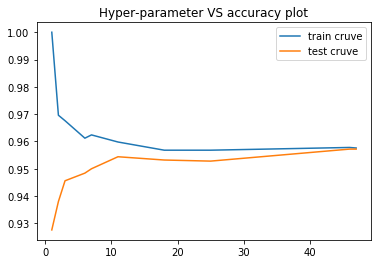

In [8]:
# 6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
plt.plot(params,trainscores, label='train cruve')
plt.plot(params,testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [9]:
params

[1, 2, 3, 6, 7, 11, 18, 25, 46, 47]

## Plotting the decision boundaries

In [11]:
# 7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

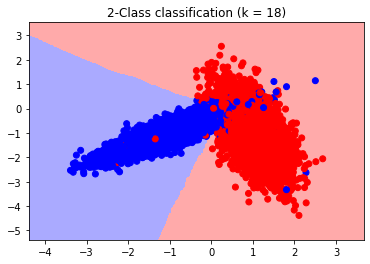

In [12]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 18)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

## Reference

Mail of randomsearch provided by appliedai

GridSearchCV coding in Assignment 4 reference

https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/

https://stackoverflow.com/questions/59841272implementing-custom-randomsearchcv-without-using-sklearn

https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/

https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search